Add this file to your google drive

https://drive.google.com/file/d/1f-aifnIpNVUEmugf9H_mgorGnE2Y9mXg/view?usp=share_link

1) Add a shortcut to this URL inside the drive


Never forget this is using 442 MB of you google drive storage until you delete it

Mount our google drive into our colab virtual machine

Be carfull with this as you could also write/erase things for your drive here

In [1]:
import glob
import sys
import pathlib


if 'google.colab' in sys.modules: # are we in colab?
  from google.colab import drive

  tarball_path = "/mnt/drive/MyDrive/century_ds.tar.gz"
  # mounting google drive
  drive.mount("/mnt/drive")

  # checking if the dataset zipfile is there
  assert pathlib.Path(tarball_path).is_file()

  # unzip the data
  print("unziping archive ... ", end="")
  !tar -xpvzf /mnt/drive/MyDrive/century_ds.tar.gz > /dev/null
  print("done!")


  print("\nunmounting the drive ... ", end="")
  # unmounting the drive
  drive.flush_and_unmount()

  # veryfying we unmounted the drive by checking if the dataset zipfile is there
  assert not pathlib.Path(tarball_path).is_file()
  print("done!")
else:
  tarball_path = "./century_ds.tar.gz" ## TODO: make this something that works for you
  assert(pathlib.Path(tarball_path)).is_file()
  print("unziping archive ... ", end="")
  !tar -xpvzf {tarball_path} > /dev/null
  print("done!")

Mounted at /mnt/drive
unziping archive ... done!

unmounting the drive ... done!


Lets install tensorboard functionallity for pytorch

In [2]:
!pip install --upgrade tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Lets import all modules we will need

In [3]:
import os
import glob
import torch
import torchvision
from PIL import Image
import random
from tqdm.auto import tqdm as tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
import torchvision.utils as vutils

Do we have cuda?

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on {device}")

Working on cpu


Lets define two preprocessing pipelines.
One for testing with a bit of augmentation.
And one for validation with no augmentation.

In [5]:
train_preprocess = torchvision.transforms.Compose([
    lambda x:x.convert("RGB"),
    torchvision.transforms.CenterCrop((400,400)),
    torchvision.transforms.RandomResizedCrop((150,150), scale=(0.08, 1.0), ratio=(0.75, 1.3)),
    #torchvision.transforms.CenterCrop(), #make sure, all the pictures are the same size
    #torchvision.transforms.AdjustBrightness(3),
    lambda x:torchvision.transforms.functional.adjust_brightness(x,1.05),
    lambda x:torchvision.transforms.functional.adjust_contrast(x,1.5),
    lambda x:torchvision.transforms.functional.adjust_sharpness(x,2.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

val_preprocess = torchvision.transforms.Compose([
    lambda x:x.convert("RGB"),
    torchvision.transforms.CenterCrop((150,150)), #make sure, all the pictures are the same size
    #torchvision.transforms.AdjustBrightness(3),
    lambda x:torchvision.transforms.functional.adjust_brightness(x,1.05),
    lambda x:torchvision.transforms.functional.adjust_contrast(x,1.5),
    lambda x:torchvision.transforms.functional.adjust_sharpness(x,2.5)
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

Lets create our dataset
It allows us a bit more data providence control

In [6]:
default_labels = ("19","20")
class CenturyDs(object):
    def __init__(self, img_paths, labels=default_labels, preprocessor=val_preprocess, label_idx=-2):
        self.img_paths = img_paths
        self.preprocessor=preprocessor
        self.labels = [cl for cl in labels]
        self.label_idx = label_idx

    def __getitem__(self, n):
        path = self.img_paths[n]
        img = Image.open(path) # Img is a PIL.Image
        img = self.preprocessor(img)# Img is now a 3D tensor
        label = path.split("/")[self.label_idx]
        #print(f"path:{path}  label:{label}")
        cl_id = self.labels.index(label)  # id is 0,1
        return img, cl_id
        
    def __len__(self):
        return len(self.img_paths)

Lets set some parameters that affect the training
Lets also find a nice filename for out experiments

In [7]:
batch_size =32
lr = 1e-3 # 1e-3 is a default lr value for Adam
dropout_prob = .25
experiment_name = f"train_prepro_deepds{batch_size}_do{int(dropout_prob*100)}_lr{int(100000*lr):05}"
print(experiment_name)

train_prepro_deepds32_do25_lr00100


Lets partition our data.
The moment we relise we will be looking at performance before commiting totally to a training regiment we realise we need a validation test as well.

In [8]:
img_paths=list(glob.glob("century_ds/*/*.jpg"))
print(f"Loaded {len(img_paths)} images")

shuffled_paths = [p for p in img_paths]
random.Random(1337).shuffle(shuffled_paths) # Random(1337) - das gibt uns die stabilität für den Untericht?? 
#Yahwohl! :P no german in code, Stabillity while mixing classes for balanced partitioning

train_paths, val_paths, test_paths = shuffled_paths[:800], shuffled_paths[800:1000], shuffled_paths[1000:]


train_ds = CenturyDs(train_paths,preprocessor = train_preprocess)
val_ds = CenturyDs(test_paths,preprocessor = val_preprocess)
test_ds = CenturyDs(test_paths,preprocessor = val_preprocess)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = batch_size, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = True)

Loaded 1298 images


Lets what an input looks like
Just to be safe

0
torch.Size([3, 150, 150])


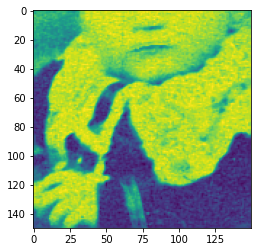

In [9]:
x, y = train_ds[8]
plt.imshow(x.numpy()[0])
print(y)
print(x.shape)

Lets define our own simple model

In [10]:
class OurNet(nn.Module):
    def __init__(self, n_channels=3, dropout_prob=0.0):
        super().__init__()
        self.conv_dropout = nn.Dropout2d(dropout_prob)
        self.fc_dropout = nn.Dropout(dropout_prob)
        self.conv1 = nn.Conv2d(n_channels, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool6 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 768)
        self.fc3 = nn.Linear(768, 2)

    def forward(self, x):
        if self.training:  # TODO(anguelos) verify this is redundant
            cdo = lambda x:self.conv_dropout(x)
            do = lambda x:self.fc_dropout(x)
        else:
            cdo = lambda x:x
            do = lambda x:x
        x = self.pool1(F.relu(self.conv1(x)))
        x = cdo(self.pool2(F.relu(self.conv2(x))))
        x = cdo(self.pool3(F.relu(self.conv3(x))))
        x = cdo(self.pool4(F.relu(self.conv4(x))))
        x = cdo(self.pool5(F.relu(self.conv5(x))))
        x = cdo(self.pool6(F.relu(self.conv6(x))))
        #print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = do(F.relu(self.fc1(x)))
        x = do(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

def count_parameters(model):
  return sum([t.view(-1).size(0) for t in model.parameters()])

print(f"OurNet size={count_parameters(OurNet())}")

OurNet size=2895778


Lets instatiate our model
Link it to an optimiser
and decide a Loss function for training
Since the optimizer is new, we should reset epochs

In [11]:
model = OurNet(n_channels=3, dropout_prob=dropout_prob)

optimizer = optim.Adam(model.parameters(), lr=lr)

lossfn = nn.CrossEntropyLoss()

epoch = 0

Lets log things!

In [12]:
import tensorboardX
from tensorboardX import SummaryWriter
%load_ext tensorboard
%reload_ext tensorboardX
writer = SummaryWriter()

In [13]:
def train_epoch(dl, model, optimiser, lossfn, device=device, epochnum=-1):
    model = model.to(device) # redundant
    model.train(True) # make it train mode
    predictions, targets, losses = [], [], []
    
    for input_batch, target_batch in tqdm(dl):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        optimiser.zero_grad() # reset gradient accumulation
        output_batch = model(input_batch)
        _, batch_prediction = output_batch.detach().max(dim=1)
        loss = lossfn(output_batch,target_batch)
        loss.backward()# minize
        optimiser.step() # apply gradients on the weight
        _, batch_prediction = output_batch.detach().max(dim=1)
        losses.append(loss.detach().cpu())
        predictions.append(batch_prediction)
        targets.append(target_batch.detach())
    predictions, targets = [torch.cat(t, dim=0).cpu().numpy() for t in (predictions, targets)]
    acc = (predictions==targets).mean()
    return acc, predictions, targets, np.array(losses)

In [14]:
!ls runs/
%tensorboard --logdir runs

Feb10_09-25-00_2dc0d9ec8b10  Feb10_10-32-35_2dc0d9ec8b10
Feb10_09-26-22_2dc0d9ec8b10  Feb10_10-39-13_2dc0d9ec8b10
Feb10_09-28-50_2dc0d9ec8b10  Feb10_10-49-32_2dc0d9ec8b10
Feb10_09-35-19_2dc0d9ec8b10  Feb10_10-57-39_2dc0d9ec8b10
Feb10_09-52-32_2dc0d9ec8b10  Feb10_11-07-19_2dc0d9ec8b10
Feb10_10-00-16_2dc0d9ec8b10  Feb10_11-20-14_2dc0d9ec8b10
Feb10_10-07-34_2dc0d9ec8b10  Feb10_11-26-46_2dc0d9ec8b10


<IPython.core.display.Javascript object>

In [15]:
def eval_epoch(dl, model, device=device):
    model = model.to(device) # redundant
    model.train(False) # no train mode
    predictions, targets, confidences = [], [], []
    with torch.no_grad():
        for input_batch, target_batch in tqdm(dl):
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            output_batch = model(input_batch)
            output_batch = torch.softmax(output_batch, dim=1)
            confidence, batch_prediction = output_batch.max(dim=1)
            predictions.append(batch_prediction)
            confidences.append(confidence)
            targets.append(target_batch)
    predictions, targets, confidences = [torch.cat(t, dim=0).cpu().numpy() for t in (predictions, targets, confidences)]
    acc = (predictions==targets).mean()
    # anguelos: better avoid printing inside a function returning accuracy
    return acc, predictions, targets, confidence

accuracy, all_predictions, all_gt, confidences = eval_epoch(test_dl, model, device=device)
print(f"Accuracy at epoch {epoch} {accuracy}")

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy at epoch 0 0.5134228187919463


Main training loop:
If we whish to train more, we can just change the loop condition.

In [16]:
writer.add_image('data/sample_input', train_ds[0][0], 0)
while epoch<3:
    tr_acc, tr_predictions, tr_targets, tr_losses = train_epoch(train_dl, model, optimizer, lossfn, device=device)
    writer.add_scalar('data/train_accuracy', tr_acc, epoch)
    writer.add_scalar('data/train_loss', tr_losses.mean(), epoch)
    writer.add_scalar('data/train_loss_deviation', tr_losses.std(), epoch)
    val_acc, val_predictions, val_targets, val_confidences = eval_epoch(val_dl, model, device=device)
    writer.add_scalar('data/val_accuracy', val_acc, epoch)
    writer.add_histogram('data/val_certainty', val_confidences, epoch)
    writer.flush()
    torch.save(model.state_dict(),f"{experiment_name}.pt") # if inside colab we need to put the file somewere else, this will no persist
    epoch+=1

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Lets create a new model and restore weights

In [17]:
accuracy, all_predictions, all_gt, confidences = eval_epoch(test_dl, model, device=device)
print(f"Accuracy at epoch {epoch} {accuracy}")

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy at epoch 3 0.7684563758389261


If we wish to resume training we should go and rerun all cells from creating the optimiser